In [27]:
from typing import Union, Any
import matplotlib.pyplot as plt
%matplotlib inline

In [28]:
with open('names.txt') as f:
    content = f.read()
    words = content.splitlines()
len(words)

32033

In [29]:
chars = sorted(list(set(''.join(words))))
stoi = { s: i+1 for i, s in enumerate(chars) }
stoi['.'] = 0
itos = { i: s for s, i in stoi.items() }
vocab_size = len(itos)

In [30]:
import jax
import jax.numpy as jnp

# Build dataset splits
def build_dataset(words: list[str], block_size: int) -> (jnp.array, jnp.array):
    x, y = [], []
    for w in words:
        #print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            x.append(context)
            y.append(ix)
            #print(''.join(itos[i] for i in context), "--->", ch)
            # Advance the rolling window of context
            context = context[1:] + [ix]
    X = jnp.array(x)
    Y = jnp.array(y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

CONTEXT_SZ = 3
Xtr, Ytr = build_dataset(words[:n1], CONTEXT_SZ)
Xdev, Ydev = build_dataset(words[n1:n2], CONTEXT_SZ)
Xte, Yte = build_dataset(words[n2:], CONTEXT_SZ)

(182625, 3) (182625,)
(22655, 3) (22655,)
(22866, 3) (22866,)


# Model

In [31]:
from flax import linen as nn

EMBED_SZ = 24
HIDDEN_LAYER_SZ = 128

class Model(nn.Module):
    """Replicating makemore backprop with flax"""

    vocab_size: int

    def setup(self) -> None:
        """Assign submodules"""
        self.embed = nn.Embed(vocab_size, EMBED_SZ)


    @nn.compact
    def __call__(self, x: jnp.array, train: bool) -> jnp.array:
        """Forward pass."""
        x = self.embed(x)
        x = jnp.reshape(x, (x.shape[0], -1))

        x = nn.Dense(HIDDEN_LAYER_SZ)(x)
        x = nn.BatchNorm(use_running_average=not train)(x)
        x = nn.leaky_relu(x)

        x = nn.Dense(HIDDEN_LAYER_SZ)(x)
        x = nn.BatchNorm(use_running_average=not train)(x)
        x = nn.leaky_relu(x)

        x = nn.Dense(HIDDEN_LAYER_SZ)(x)
        x = nn.BatchNorm(use_running_average=not train)(x)
        x = nn.leaky_relu(x)

        x = nn.Dense(vocab_size)(x)
        x = nn.BatchNorm(use_running_average=not train)(x)
        return x


In [32]:

MINI_BATCH_SZ = 128

model = Model(vocab_size=vocab_size)


def random_batch_index(key: jax.random.PRNGKey) -> jnp.array:
    return jax.random.randint(subkey, shape=(MINI_BATCH_SZ,), minval=0, maxval=Xtr.shape[0])


key = jax.random.PRNGKey(0)
key, subkey = jax.random.split(key)
ix = random_batch_index(subkey)
Xb, Yb = Xtr[ix], Ytr[ix]

print(model.tabulate(subkey, Xb, console_kwargs={'width': 120}, train=True))



                                                   Model Summary                                                   
┏━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃ path        ┃ module    ┃ inputs           ┃ outputs           ┃ params                    ┃ batch_stats        ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│             │ Model     │ - int32[128,3]   │ float32[128,27]   │                           │                    │
│             │           │ - train: True    │                   │                           │                    │
├─────────────┼───────────┼──────────────────┼───────────────────┼───────────────────────────┼────────────────────┤
│ embed       │ Embed     │ int32[128,3]     │ float32[128,3,24] │ embedding: float32[27,24] │                    │
│             │           │                  │                   │     

In [33]:
from statistics import mean
#from tqdm.notebook import tqdm
from tqdm import tqdm
from clu import metrics
from flax.training import train_state  # Useful dataclass to keep train state
from flax import struct                # Flax dataclasses
import optax                           # Common loss functions and optimizers
from collections.abc import Callable


@struct.dataclass
class Metrics(metrics.Collection):
    accuracy: metrics.Accuracy
    loss: metrics.Average.from_output('loss')


class TrainState(train_state.TrainState):
    metrics: Metrics
    batch_stats: Any


def create_train_state(
        module: nn.Module,
        rng: jax.random.PRNGKey,
        data: jnp.array,
        tx: optax.GradientTransformation,
) -> TrainState:
    """Creates an initial `TrainState`."""
    init = module.init(rng, data, train=True)
    return TrainState.create(
        apply_fn=module.apply,
        params=init['params'],
        tx=tx,
        batch_stats=init['batch_stats'],
        metrics=Metrics.empty(),
    )

@jax.jit
def train_step(state, X, Y):
    """Train for a single step."""

    def loss_fn(params, batch_stats):
        logits, updates = state.apply_fn(
            {
                'params': params,
                'batch_stats': batch_stats
            },
            x=X,
            train=True,
            mutable=['batch_stats']
        )
        loss = optax.softmax_cross_entropy_with_integer_labels(
            logits=logits,
            labels=Y
        ).mean()
        return loss, (logits, updates)
    
    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (loss, (logits, updates)), grads = grad_fn(state.params, state.batch_stats)
    state = state.apply_gradients(grads=grads)
    state = state.replace(batch_stats=updates['batch_stats'])
    return state

@jax.jit
def compute_metrics(state, X, Y):
    logits = state.apply_fn({
        'params': state.params,
        'batch_stats': state.batch_stats
        }, x=X, train=False)
    loss = optax.softmax_cross_entropy_with_integer_labels(
            logits=logits,
            labels=Y
    ).mean()
    metric_updates = state.metrics.single_from_model_output(
        logits=logits,
        labels=Y,
        loss=loss
    )
    metrics = state.metrics.merge(metric_updates)
    state = state.replace(metrics=metrics)
    return state

key, subkey = jax.random.split(key)
ix = random_batch_index(subkey)
Xb, Yb = Xtr[ix], Ytr[ix]


steps = 120000
schedule = optax.warmup_cosine_decay_schedule(
    init_value=10**-1,
    peak_value=10**-1,
    warmup_steps=steps*0.40,
    decay_steps=steps,
    end_value=10**-5,
)

#learning_rate = 0.01
momentum = 0.9
#momentum = 0.001

tx = optax.sgd(learning_rate=schedule, momentum=momentum)
#tx = optax.adamw(learning_rate=schedule, weight_decay=momentum)


key, subkey = jax.random.split(key)
state = create_train_state(model, subkey, Xb, tx)

num_steps_per_epoch = 1000
metrics_history = {'train_loss': [],
                   'train_logloss': [],
                   'train_accuracy': []}

pbar = tqdm(range(steps))
for i in pbar:
    # Calculate a single batch
    key, subkey = jax.random.split(key)
    ix = random_batch_index(subkey)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # Run optimization steps over training batches and compute batch metrics
    state = train_step(state, Xb, Yb) # get updated train state (which contains the updated parameters)
    state = compute_metrics(state, Xb, Yb) # aggregate batch metrics

    if (i+1) % num_steps_per_epoch == 0: # one training epoch has passed
        met = state.metrics.compute()
        for metric, value in met.items(): # compute metrics
           metrics_history[f'train_{metric}'].append(value) # record metrics
        metrics_history["train_logloss"].append(jnp.log(met["loss"]))
        state = state.replace(metrics=state.metrics.empty()) # reset train_metrics for next training epoch
        loss = metrics_history["train_loss"]
        if loss:
            pbar.set_description("LR: %0.5f, Loss %0.4f" % (schedule(i+1), loss[-1]))


LR: 0.00001, Loss 1.9264: 100%|██████████| 120000/120000 [04:35<00:00, 434.79it/s]


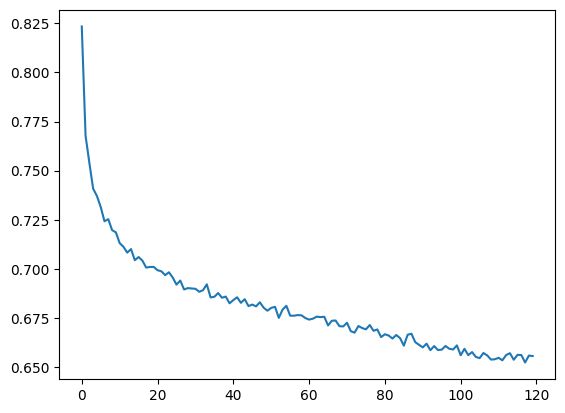

In [34]:
plt.plot(metrics_history["train_logloss"])

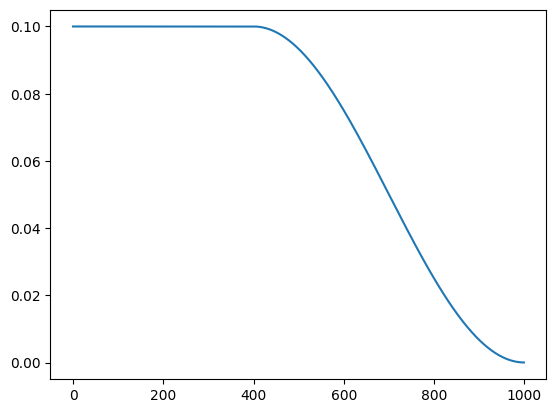

In [35]:
plt.plot([ schedule(i) for i in range(0, steps, int(steps/1000)) ])

# View Results

In [36]:
print({
    'MINI_BATCH_SZ': MINI_BATCH_SZ,
    'CONTEXT_SZ': CONTEXT_SZ,
    'EMBED_SZ': EMBED_SZ,
    'HIDDEN_LAYER_SZ': HIDDEN_LAYER_SZ,
})

logits = state.apply_fn({
    'params': state.params,
    'batch_stats': state.batch_stats
    }, x=Xtr, train=False)
xtr_loss = optax.softmax_cross_entropy_with_integer_labels(
    logits=logits, labels=Ytr).mean()
print(f"Xtr loss: {xtr_loss:0.4f}")

logits = state.apply_fn({
    'params': state.params,
    'batch_stats': state.batch_stats
    }, x=Xdev, train=False)
xdev_loss = optax.softmax_cross_entropy_with_integer_labels(
    logits=logits, labels=Ydev).mean()
print(f"Xdev loss: {xdev_loss:0.4f}")


{'MINI_BATCH_SZ': 128, 'CONTEXT_SZ': 3, 'EMBED_SZ': 24, 'HIDDEN_LAYER_SZ': 128}
Xtr loss: 1.9249
Xdev loss: 2.0769


# Sample from the model

In [37]:
for _ in range(20):
    out = []
    context = [0] * CONTEXT_SZ
    while True:
        x = jnp.array([context])
        logits = state.apply_fn({
            'params': state.params,
            'batch_stats': state.batch_stats
            }, x=x, train=False)

        # Sample from probabilities
        key, subkey = jax.random.split(key)
        ix = jax.random.categorical(subkey, logits, axis=1)[0]
        context = context[1:] + [ix]
        out.append(itos[int(ix)])
        if ix == 0:
            break
    print(''.join(out))

ken.
khaleigh.
mark.
rayson.
kynleyianaldon.
yianner.
reckington.
remernar.
gursen.
sammed.
zacion.
aarynn.
obellissandrianoreon.
callarius.
lora.
makhiri.
gurneralynn.
mazel.
ttrevany.
adin.


# Results


## Single Linear Layer

```
{'MINI_BATCH_SZ': 32, 'CONTEXT_SZ': 3, 'EMBED_SZ': 10, 'HIDDEN_LAYER_SZ': 64}
Xtr loss: 2.1687
Xdev loss: 2.1772
```

## Three Linear Layers

```
{'MINI_BATCH_SZ': 32, 'CONTEXT_SZ': 3, 'EMBED_SZ': 10, 'HIDDEN_LAYER_SZ': 64}
Xtr loss: 2.1068
Xdev loss: 2.1392
```

## Increased Layer Sizes

```
{'MINI_BATCH_SZ': 32, 'CONTEXT_SZ': 3, 'EMBED_SZ': 24, 'HIDDEN_LAYER_SZ': 128}
Xtr loss: 2.0340
Xdev loss: 2.1019
```

## Learning Rate Modifications

{'MINI_BATCH_SZ': 32, 'CONTEXT_SZ': 3, 'EMBED_SZ': 24, 'HIDDEN_LAYER_SZ': 128}
Xtr loss: 2.0940
Xdev loss: 2.1264


## Learning Rate Schedule and Batch Size

The learning rate schedule is using `warmup_cosine_decay_schedule` and 120k steps,
and `optax.sgd`.

```
{'MINI_BATCH_SZ': 128, 'CONTEXT_SZ': 3, 'EMBED_SZ': 24, 'HIDDEN_LAYER_SZ': 128}
Xtr loss: 1.9259
Xdev loss: 2.0883
```

## Add extra batch norm layer

Added an extra batchnorm layer at the end of the network:

```
{'MINI_BATCH_SZ': 128, 'CONTEXT_SZ': 3, 'EMBED_SZ': 24, 'HIDDEN_LAYER_SZ': 128}
Xtr loss: 1.9249
Xdev loss: 2.0769
```

In [38]:
jax.devices()

[CpuDevice(id=0)]